In [1]:
#should be abj
!conda info | grep enviro

     active environment : abj
       base environment : /home/z/miniconda3  (writable)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from denoising_diffusion_pytorch.denoising_diffusion_pytorch import *

## Plot noise blending schedules from 
    Denoising Diffusion Probabilistic Models
    Improving DDPM ( beta schedule) 
    

#### Noise step
$ q(\mathbf{x}_t|\mathbf{x}_0) = \mathcal{N} (\mathbf{x}_t; \sqrt{ \Pi\alpha_t}\mathbf{x}_0, (1 - \Pi\alpha_t)\mathbf{I}) $ 

$\beta_1 = 10^{-4} \ to \ \beta_T = 0.02$

In [3]:

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = np.linspace(0, steps, steps)
    alphas_cumprod = np.cos(((x / steps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, a_min = 0, a_max = 0.999)

# original beta schedules
#
def _warmup_beta(beta_start, beta_end, timesteps, warmup_frac):
    betas = beta_end * np.ones(timesteps, dtype=np.float64)
    warmup_time = int(timesteps * warmup_frac)
    betas[:warmup_time] = np.linspace(beta_start, beta_end, warmup_time, dtype=np.float64)
    return betas

def get_beta_schedule(beta_schedule, *, timesteps, beta_start=0, beta_end=.999):
    if beta_schedule == 'quad':
        betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, timesteps, dtype=np.float64) ** 2
    elif beta_schedule == 'linear':
        betas = np.linspace(beta_start, beta_end, timesteps, dtype=np.float64)
    elif beta_schedule == 'warmup10':
        betas = _warmup_beta(beta_start, beta_end, timesteps, 0.1)
    elif beta_schedule == 'warmup50':
        betas = _warmup_beta(beta_start, beta_end, timesteps, 0.5)
    elif beta_schedule == 'const':
        betas = beta_end * np.ones(timesteps, dtype=np.float64)
    elif beta_schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(timesteps, 1, timesteps, dtype=np.float64)
    elif beta_schedule == "cos":
        betas = cosine_beta_schedule(timesteps=timesteps)
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (timesteps,)
    return betas


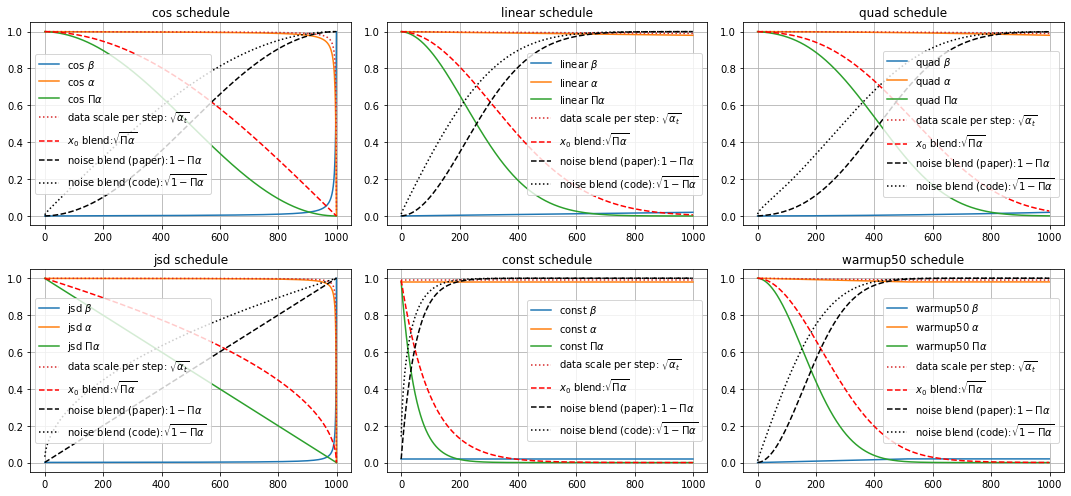

In [4]:
def plt_sched(sched, beta, subplot=None):
    if subplot is not None:
        plt.subplot(*subplot)
    plt.title(f"{sched} schedule")
    alpha = 1 - beta
    plt.plot(beta, label=f"{sched} "+"$\\beta$")
    plt.plot(alpha, label=f"{sched} "+"$\\alpha$")
    plt.plot(np.cumprod(alpha), label=f"{sched} "+"$\\Pi \\alpha$")
    plt.plot(np.sqrt(alpha), label="data scale per step: $\\sqrt{\\alpha_t}$", linestyle=":")

    plt.plot(np.sqrt(np.cumprod(alpha)), label="$x_0$ blend:"+"$\\sqrt{\\Pi \\alpha}$", linestyle="--", color="red")
    plt.plot(1 - np.cumprod(alpha), label="noise blend (paper):"+"$1 - \\Pi \\alpha$", linestyle="--", color="black")
    plt.plot(np.sqrt(1 - np.cumprod(alpha)), label="noise blend (code):"+"$\\sqrt{1 - \\Pi \\alpha}$", linestyle=":", color="black")
    plt.grid()
    plt.legend()
ncols=3
nrows = 2
plt.figure(figsize=(15,7))

i=1

sched = "cos"
beta = cosine_beta_schedule(timesteps=1000)
plt_sched(sched, beta, (nrows, ncols, i));i+=1


sched = "linear"
beta = get_beta_schedule(sched, timesteps=1000, beta_start=1e-4, beta_end=0.02)
plt_sched(sched, beta, (nrows, ncols, i));i+=1

sched = "quad"
beta = get_beta_schedule(sched, timesteps=1000, beta_start=1e-4, beta_end=0.02)
plt_sched(sched, beta, (nrows, ncols, i));i+=1

sched = "jsd"
beta = get_beta_schedule(sched, timesteps=1000, beta_start=1e-4, beta_end=0.02)
plt_sched(sched, beta, (nrows, ncols, i));i+=1

sched = "const"
beta = get_beta_schedule(sched, timesteps=1000, beta_start=1e-4, beta_end=0.02)
plt_sched(sched, beta, (nrows, ncols, i));i+=1

sched = "warmup50"
beta = get_beta_schedule(sched, timesteps=1000, beta_start=1e-4, beta_end=0.02)
plt_sched(sched, beta, (nrows, ncols, i));i+=1

plt.tight_layout()
plt.show()

## sampling code for DDPM
sqrt_recip_alphas_cumprod = $ \sqrt{\frac{1}{\overline{\alpha}_{t-1}}}$

sqrt_recipm1_alphas_cumprod =  $ \sqrt{\frac{1}{{\overline{\alpha}_{t-1}}} -1}$

posterior_mean_coef1 = $ \frac{(1-\overline{\alpha}_{t-1}) \sqrt{\overline{\alpha}_{t}}}{1- \overline{\alpha}_{t-1}}$

posterior_mean_coef2 = $ \frac{(1-\overline{\alpha}_{t})\sqrt{\alpha_{t-1}}}{1- \overline{\alpha}_{t-1}}$

posterior_log_variance_clipped = $log( \beta \frac{1 - \overline{\alpha}_{t}} {1 - \overline{\alpha}_{t-1}})$

$x_{t-1} = x_t \sqrt{\frac{1}{\overline{\alpha}_{t-1}}} - \mathbf{z}_{\theta}(x_t, t) \sqrt{\frac{1}{{\overline{\alpha}_{t-1}}} -1} $

$x_{t-1} = \frac{x_{t-1}(1-\overline{\alpha}_{t-1}) \sqrt{\overline{\alpha}_{t}} \space+\space x_t(1-\overline{\alpha}_{t})\sqrt{{\alpha}_{t-1}}}{1- \overline{\alpha}_{t-1}} $

$x_{t-1} = x_{t-1} + x e^{log( \beta \frac{1 - \overline{\alpha}_{t}} {1 - \overline{\alpha}_{t-1}})}$

### Visualize blending coefficients, between x_t and denoise(x_t, t)

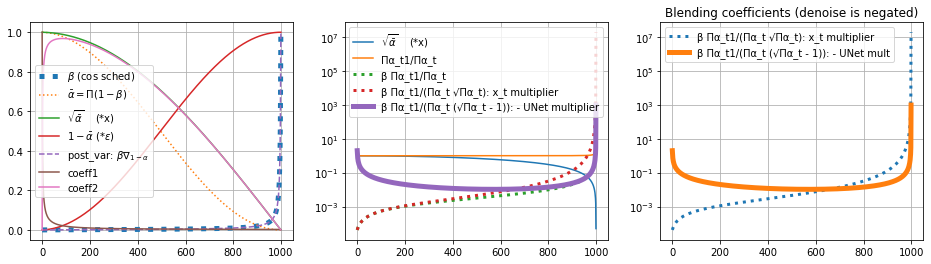

In [5]:
## 
beta = cosine_beta_schedule(1000)
alpha = np.cumprod(1-beta) # 0.999958715775178 ...

alpha_t1 = np.append(1, alpha[:-1]) # 1,...
post_var = beta*(1-alpha_t1)/(1-alpha)
post_logvar = np.log(np.maximum(post_var, 1e-20))
coeff1 = beta * np.sqrt(alpha_t1) / (1. - alpha)
coeff2 =(1. - alpha_t1) * np.sqrt(alpha) / (1. - alpha)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(beta, label="$\\beta$ (cos sched)", linestyle=":", linewidth=5)
plt.plot(alpha, label="$\\bar{\\alpha} = \Pi(1-\\beta)$", linestyle=":")
plt.plot(np.sqrt(alpha), label="$\\sqrt{\\bar{\\alpha}}$    (*x)")
plt.plot(1-alpha, label="$1-\\bar{\\alpha}$ (*$\epsilon$)")
plt.plot(post_var, label="post_var: $\\beta\\nabla_{1-\\alpha}$", linestyle="--")

plt.plot(coeff1, label="coeff1")
plt.plot(coeff2, label="coeff2")
plt.legend()
plt.grid()
# plt.plot(post_logvar, label="post_logvar", )

plt.subplot(132)

plt.plot(np.sqrt(alpha), label="$\\sqrt{\\bar{\\alpha}}$    (*x)")
plt.plot(np.append(1, alpha)[:-1]/alpha, label="Πα_t1/Πα_t")
plt.plot(beta*np.append(1, alpha)[:-1]/alpha, label="β Πα_t1/Πα_t ", linestyle=":", linewidth=3)
plt.plot(beta*np.append(1, alpha)[:-1]/(alpha*np.sqrt(alpha)), label="β Πα_t1/(Πα_t √Πα_t): x_t multiplier", linestyle=":", linewidth=3)
plt.plot(np.abs(beta*np.append(1, alpha)[:-1]/(alpha*(np.sqrt(alpha) - 1))), label="β Πα_t1/(Πα_t (√Πα_t - 1)): - UNet multiplier", linewidth=5)
plt.grid()
plt.legend()
plt.yscale("log")
plt.subplot(133)
plt.title("Blending coefficients (denoise is negated)")
plt.plot(beta*np.append(1, alpha)[:-1]/(alpha*np.sqrt(alpha)), label="β Πα_t1/(Πα_t √Πα_t): x_t multiplier", linestyle=":", linewidth=3)
plt.plot(np.abs(beta*np.append(1, alpha)[:-1]/(alpha*(np.sqrt(alpha) - 1))), label="β Πα_t1/(Πα_t (√Πα_t - 1)): - UNet mult", linewidth=5)
plt.grid()
plt.legend()
plt.yscale("log")

plt.show()

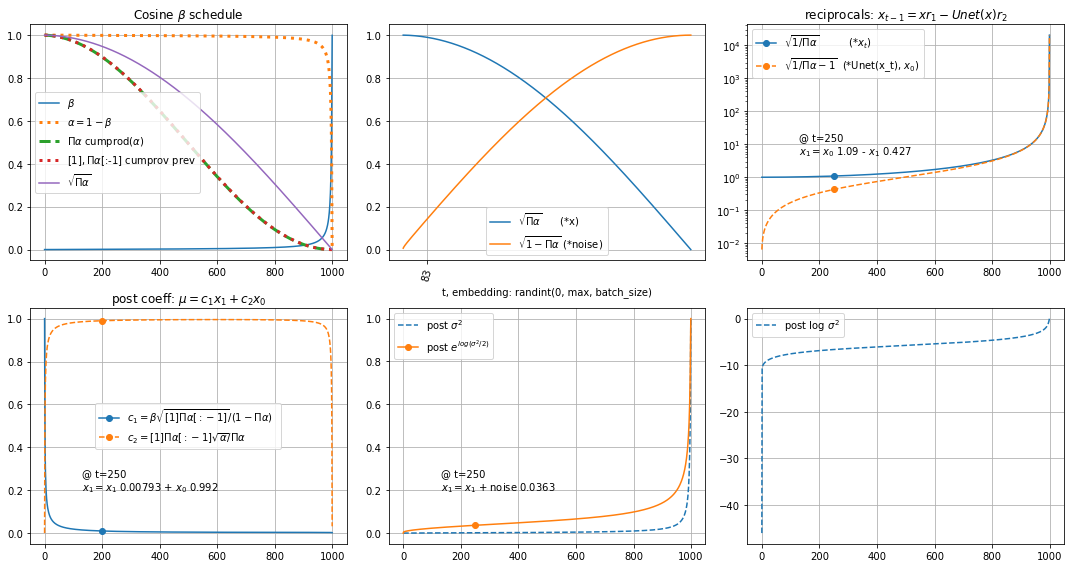

In [6]:
model = Unet(dim = 64, dim_mults = (1, 2, 4, 8))

self = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,   # number of steps
    loss_type = 'l1'    # L1 or L2
)
x = torch.randn(1,3,128,128)
b, c, h, w, device, img_size, = *x.shape, x.device, self.image_size
t = torch.randint(0, self.num_timesteps, (b,), device=device).long()


plt.figure(figsize=(15,8))
c=3
r=2
plt.subplot(r,c,1)
import numpy as np

betas = cosine_beta_schedule(1000)
alphas = 1 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])

_example = 250


plt.title("Cosine $\\beta$ schedule")
plt.plot(betas, label="$\\beta$")
plt.plot(1-betas, label="$\\alpha = 1-\\beta$", linestyle=":", linewidth=3)
# plt.plot(alphas, label="$\\alpha = 1 - \\beta$")
plt.plot(alphas_cumprod, label="$\\Pi\\alpha$ cumprod($\\alpha$)", linestyle="--", linewidth=3)
plt.plot(alphas_cumprod_prev, label="$[1],\\Pi\\alpha$[:-1] cumprov prev", linestyle=":", linewidth=3)
plt.plot(np.sqrt(alphas_cumprod), label="$\\sqrt{\\Pi\\alpha}$")
plt.legend()
plt.grid()

plt.subplot(r,c,2)
plt.plot(self.sqrt_alphas_cumprod.clone().detach(), label="$\\sqrt{ \\Pi\\alpha}$      (*x)")
plt.plot(self.sqrt_one_minus_alphas_cumprod.clone().detach(), label="$\\sqrt{1 - \\Pi\\alpha}$ (*noise)")

# sqrt_recip_alphas_cumprod = np.sqrt(1. / alphas_cumprod)
# sqrt_recipm1_alphas_cumprod = np.sqrt(1. / alphas_cumprod - 1)
plt.xticks(sorted(t.tolist()), rotation=75)
plt.grid()
plt.legend()
plt.xlabel("t, embedding: randint(0, max, batch_size)")


plt.subplot(r,c,3)
# np.sqrt(1. / alphas_cumprod))
plt.title("reciprocals: $x_{t-1} = x r_1 - Unet(x) r_2 $")
recip_a = self.sqrt_recip_alphas_cumprod.clone().detach()
recip_1_a = self.sqrt_recipm1_alphas_cumprod.clone().detach()
plt.plot(recip_a, label="$\\sqrt{1/\\Pi \\alpha}$          (*$x_t$)",
         markevery=[_example], marker='o')
plt.plot(recip_1_a,
         label="$\\sqrt{1/\\Pi\\alpha -1}$  (*Unet(x_t), $x_0$)", linestyle="--", markevery=[_example], marker='o')
plt.text(130,5, f"@ t={_example} \n$x_1=x_0$ {recip_a[_example].item():.3} - $x_1$ {recip_1_a[_example].item():.3}")
plt.grid()
plt.legend()
plt.yscale("log")
plt.subplot(r,c,4)

plt.title("post coeff: $\mu = c_1 x_1 + c_2 x_0$")
_c1 = self.posterior_mean_coef1
_c2 = self.posterior_mean_coef2

# betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod))
plt.plot(_c1, label="$c_1 =\\beta\\sqrt{[1]\\Pi\\alpha[:-1]}/(1-\\Pi \\alpha)$  ",
         markevery=[200], marker='o')
plt.plot(_c2, label="$c_2 =[1]\\Pi\\alpha[:-1] \\sqrt{\\alpha}/\\Pi \\alpha$  ",
         markevery=[200], marker='o', linestyle="--")

plt.text(130,0.2, f"@ t={_example} \n$x_1=x_1$ {_c1[_example].item():.3} + $x_0$ {_c2[_example].item():.3}")

plt.grid()
plt.legend()


plt.subplot(r,c,5)
_logvar = torch.exp(self.posterior_log_variance_clipped/2)
plt.plot(self.posterior_variance, label="post $\\sigma^2$", linestyle="--")
plt.plot(_logvar, label="post $e^{log (\\sigma^2/2)}$",
        markevery=[_example], marker='o')

plt.text(130,0.2, f"@ t={_example} \n$x_1=x_1$ + noise {_logvar[_example].item():.3}")

plt.grid()
plt.legend()

plt.subplot(r,c,6)
plt.plot(self.posterior_log_variance_clipped, label="post log $\\sigma^2$", linestyle="--")
plt.legend()
plt.grid()

plt.tight_layout()

plt.show()